# Object Detection with Street View House Numbers

This notebook illustrates how to build a deep CNN using Keras’ functional API to generate multiple outputs: one to predict how many digits are present, and five for the value of each in the order they appear.

## Imports & Settings

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (Flatten,
                                     Dense,
                                     BatchNormalization,
                                     Activation,
                                     Concatenate)
from tensorflow.keras import backend as K
from matplotlib.ticker import FuncFormatter

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
sns.set_style('whitegrid')

In [4]:
data_path = Path('images', 'svhn')

In [5]:
results_path = Path('results', 'svhn')
if not results_path.exists():
    results_path.mkdir()

### Settings

In [6]:
IMG_SIZE = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
SEQ_LENGTH = 4
N_CLASSES = 11

## Load Data 

In [7]:
X_train = np.load(data_path / 'X_train.npy')
y_train = np.load(data_path / 'y_train.npy')

Removing the rare cases of 5-digit house numbers.

In [8]:
X_train = X_train[y_train[:, 0] < 5]
y_train = y_train[y_train[:, 0] < 5, :5]
y_train[:, 0] -= 1

In [9]:
X_test = np.load(data_path / 'X_test.npy')
y_test = np.load(data_path / 'y_test.npy')

In [10]:
X_test = X_test[y_test[:, 0] < 5]
y_test = y_test[y_test[:, 0] < 5, :5]
y_test[:, 0] -= 1

In [11]:
pd.DataFrame(y_train).nunique()

0     4
1    10
2    11
3    11
4    11
dtype: int64

In [12]:
y_train.shape

(33392, 5)

## Best Architecture

[Multi-digit Number Recognition from Street View Imagery using Deep Convolutional Neural Networks](https://arxiv.org/abs/1312.6082), Goodfellow, et al, 2014

In [13]:
digit_pos = {1: [4, 14], 2: [14, 25], 3: [25, 36], 4: [36, 47]}

In [14]:
def weighted_accuracy(y_true, y_pred):
    n_digits_pred = K.argmax(y_pred[:, :SEQ_LENGTH], axis=1)

    digit_preds = {}
    for digit, (start, end) in digit_pos.items():
        digit_preds[digit] = K.argmax(y_pred[:, start:end], axis=1)
    preds = tf.dtypes.cast(tf.stack((n_digits_pred,
                                     digit_preds[1],
                                     digit_preds[2],
                                     digit_preds[3],
                                     digit_preds[4]), axis=1), tf.float32)

    return K.mean(K.sum(tf.dtypes.cast(K.equal(y_true, preds), tf.int64), axis=1) / 5)

In [15]:
def weighted_entropy(y_true, y_pred):
    cce = tf.keras.losses.SparseCategoricalCrossentropy()
    n_digits = y_pred[:, :SEQ_LENGTH]

    digits = {}
    for digit, (start, end) in digit_pos.items():
        digits[digit] = y_pred[:, start:end]
    return (cce(y_true[:, 0], n_digits) +
            cce(y_true[:, 1], digits[1]) +
            cce(y_true[:, 2], digits[2]) +
            cce(y_true[:, 3], digits[3]) +
            cce(y_true[:, 4], digits[4])) / 5

In [16]:
vgg16 = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
vgg16.trainable = False
x = vgg16.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(256)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
n_digits = Dense(SEQ_LENGTH, activation='softmax', name='n_digits')(x)
digit1 = Dense(N_CLASSES-1, activation='softmax', name='d1')(x)
digit2 = Dense(N_CLASSES, activation='softmax', name='d2')(x)
digit3 = Dense(N_CLASSES, activation='softmax', name='d3')(x)
digit4 = Dense(N_CLASSES, activation='softmax', name='d4')(x)
predictions = Concatenate()([n_digits, digit1, digit2, digit3, digit4])

model = Model(inputs=vgg16.input, outputs=predictions)

In [17]:
model.compile(optimizer='adam',
              loss=weighted_entropy,
              metrics=[weighted_accuracy])

As a result, the model produces five distinct outputs that we can evaluate.

## Define Callbacks

In [18]:
svhn_path = (results_path / 'svhn.weights.best.hdf5').as_posix()
checkpointer = ModelCheckpoint(filepath=svhn_path, 
                               verbose=1, 
                               monitor='val_weighted_accuracy',
                               save_best_only=True)

In [19]:
early_stopping = EarlyStopping(monitor='val_weighted_accuracy', 
                               patience=5)

## Train Transfer Model

In [20]:
epochs = 50

In [21]:
result = model.fit(x=X_train,
                    y=y_train,
                    validation_split=.1,
                    batch_size=32,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[checkpointer, early_stopping])

Epoch 1/50
940/940 [==============================] - ETA: 0s - loss: 1.0570 - weighted_accuracy: 0.6429
Epoch 00001: val_weighted_accuracy improved from -inf to 0.67796, saving model to results/svhn/cnn.weights.best.hdf5
940/940 [==============================] - 10s 11ms/step - loss: 1.0570 - weighted_accuracy: 0.6429 - val_loss: 0.9570 - val_weighted_accuracy: 0.6780
Epoch 2/50
939/940 [============================>.] - ETA: 0s - loss: 0.9246 - weighted_accuracy: 0.6835
Epoch 00002: val_weighted_accuracy improved from 0.67796 to 0.68603, saving model to results/svhn/cnn.weights.best.hdf5
940/940 [==============================] - 10s 11ms/step - loss: 0.9247 - weighted_accuracy: 0.6834 - val_loss: 0.9284 - val_weighted_accuracy: 0.6860
Epoch 3/50
937/940 [============================>.] - ETA: 0s - loss: 0.8844 - weighted_accuracy: 0.6978
Epoch 00003: val_weighted_accuracy improved from 0.68603 to 0.69097, saving model to results/svhn/cnn.weights.best.hdf5
940/940 [=================

### Evaluate Results

In [22]:
metrics = pd.DataFrame(result.history)
initial_epochs = len(metrics)

In [23]:
y_pred = model.predict(X_test, verbose=1)

409/409 [==============================] - 3s 7ms/step


In [24]:
n_digits = y_pred[:, :SEQ_LENGTH]
digits = {}
for digit, (start, end) in digit_pos.items():
    digits[digit] = y_pred[:, start:end]

In [25]:
(y_test[:, 0] == np.argmax(n_digits, axis=1)).sum()/len(n_digits)

0.829710699525486

In [27]:
confusion_matrix(y_true=y_test[:, 0], y_pred=np.argmax(n_digits, axis=1))

array([[1907,  559,   16,    1],
       [ 347, 7257,  739,   13],
       [  12,  357, 1606,  106],
       [   0,    3,   72,   71]])

In [28]:
accuracy = np.zeros_like(y_test)
accuracy[:, 0] = (y_test[:, 0] == np.argmax(n_digits, axis=1))
for i in range(1, 5):
    accuracy[:, i] = (y_test[:, i] == np.argmax(digits[i], axis=1))

In [29]:
acc_by_output = {}
for i in range(5):
    acc_by_output[i] = accuracy[:, i].sum()/accuracy[:, i].shape[0]

In [30]:
acc_up_to_out = {}
for i in range(1, 6):
    r = accuracy[:, :i].all(1)
    acc_up_to_out[i-1] = r.sum()/r.shape[0]

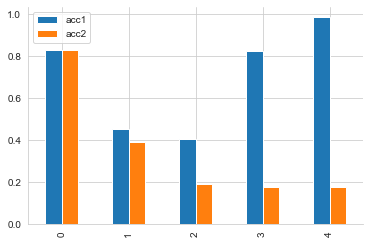

In [31]:
pd.DataFrame({'acc1': acc_by_output, 'acc2': acc_up_to_out}).plot.bar()
sns.despine();

## Fine Tune VGG16 weights

In [32]:
vgg16.trainable = True
# Fine-tune from this layer onwards
start_fine_tuning_at = 1

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:start_fine_tuning_at]:
    layer.trainable =  False

In [33]:
model.compile(optimizer='adam',
              loss=weighted_entropy,
              metrics=[weighted_accuracy])

In [34]:
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

In [35]:
result_fine_tune = model.fit(x=X_train,
                              y=y_train,
                              validation_split=.1,
                              batch_size=32,
                              epochs=total_epochs,
                              initial_epoch=history.epoch[-1],
                              callbacks=[early_stopping])

Epoch 12/62
940/940 [==============================] - 28s 30ms/step - loss: 1.1122 - weighted_accuracy: 0.6255 - val_loss: 1.4838 - val_weighted_accuracy: 0.5645
Epoch 13/62
940/940 [==============================] - 27s 29ms/step - loss: 0.7990 - weighted_accuracy: 0.7213 - val_loss: 0.7274 - val_weighted_accuracy: 0.7598
Epoch 14/62
940/940 [==============================] - 28s 29ms/step - loss: 0.5737 - weighted_accuracy: 0.8069 - val_loss: 0.6773 - val_weighted_accuracy: 0.8038
Epoch 15/62
940/940 [==============================] - 27s 29ms/step - loss: 0.4478 - weighted_accuracy: 0.8533 - val_loss: 0.5126 - val_weighted_accuracy: 0.8332
Epoch 16/62
940/940 [==============================] - 27s 29ms/step - loss: 0.3589 - weighted_accuracy: 0.8841 - val_loss: 0.3812 - val_weighted_accuracy: 0.8817
Epoch 17/62
940/940 [==============================] - 27s 29ms/step - loss: 0.3012 - weighted_accuracy: 0.9045 - val_loss: 0.5555 - val_weighted_accuracy: 0.8590
Epoch 18/62
940/940 [=

In [36]:
metrics_tuned = metrics.append(pd.DataFrame(result_fine_tune.history), ignore_index=True)

In [37]:
metrics_tuned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loss                   46 non-null     float64
 1   weighted_accuracy      46 non-null     float64
 2   val_loss               46 non-null     float64
 3   val_weighted_accuracy  46 non-null     float64
dtypes: float64(4)
memory usage: 1.6 KB


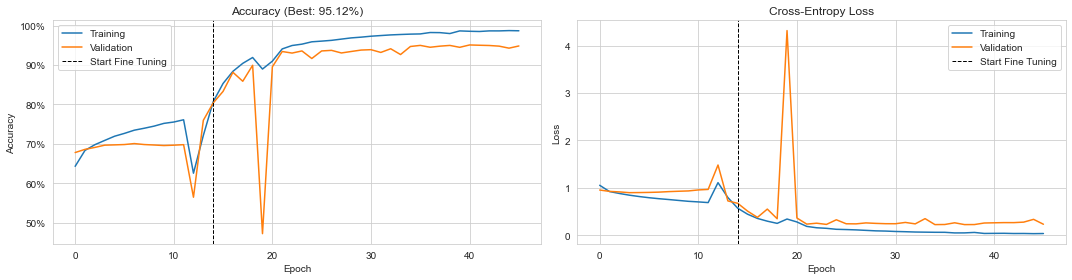

In [38]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics_tuned[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy Loss')
metrics_tuned[['weighted_accuracy', 'val_weighted_accuracy']].plot(ax=axes[0], title=f'Accuracy (Best: {metrics_tuned.val_weighted_accuracy.max():.2%})')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')
for ax in axes:
    ax.axvline(14, ls='--', lw=1, c='k')
    ax.legend(['Training', 'Validation', 'Start Fine Tuning'])
    ax.set_xlabel('Epoch')
fig.tight_layout()
fig.savefig(results_path / 'transfer_learning_svhn');